# Analyse Exploratoire

## 1) Création de Feature

### Importation des librairies de base

In [14]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Décomposition du kernel kaggle

In [2]:
# Chemin des données
path = "/Users/dubois/Documents/Openclassrooms/DS_P7/data/"

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=False):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
# Read data and merge
df = pd.read_csv(path+'application_train.csv')

# Optional: Remove 4 applications with XNA CODE_GENDER (train set)
df = df.drop(columns='CODE_GENDER')

# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df)

# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

In [5]:
bureau = pd.read_csv(path+'bureau.csv')
bb = pd.read_csv(path+'bureau_balance.csv')
bb, bb_cat = one_hot_encoder(bb)
bureau, bureau_cat = one_hot_encoder(bureau)

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                          for e in bb_agg.columns.tolist()])
bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
del bb, bb_agg
gc.collect()

# Bureau and bureau_balance numeric features
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_cat:
    cat_aggregations[cat] = ['mean']
for cat in bb_cat:
    cat_aggregations[cat + "_MEAN"] = ['mean']

bureau_agg = bureau.groupby('SK_ID_CURR').agg(
    {**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(
    ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(
    ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()

# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(
    ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')


df = df.join(bureau_agg, how='left', on='SK_ID_CURR')
del bureau, closed, closed_agg, bureau_agg
gc.collect()

0

In [6]:
prev = pd.read_csv(path+'previous_application.csv')
prev, cat_cols = one_hot_encoder(prev, nan_as_category=False)
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg(
    {**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper()
                            for e in prev_agg.columns.tolist()])
# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(
    ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(
    ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')


df = df.join(prev_agg, how='left', on='SK_ID_CURR')
del prev_agg, refused, refused_agg, approved, approved_agg, prev
gc.collect()

0

In [7]:
# Preprocess POS_CASH_balance.csv

pos = pd.read_csv(path+'POS_CASH_balance.csv')
pos, cat_cols = one_hot_encoder(pos, nan_as_category=False)
# Features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper()
                           for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()


df = df.join(pos_agg, how='left', on='SK_ID_CURR')
del pos, pos_agg
gc.collect()

0

In [8]:
# Preprocess installments_payments.csv
ins = pd.read_csv(path+'installments_payments.csv')
ins, cat_cols = one_hot_encoder(ins)
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper()
                           for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()


df = df.join(ins_agg, how='left', on='SK_ID_CURR')
del ins_agg, ins
gc.collect()

0

In [9]:
# Preprocess credit_card_balance.csv
cc = pd.read_csv(path+'credit_card_balance.csv')
cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)
# General aggregations
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                          for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()


df = df.join(cc_agg, how='left', on='SK_ID_CURR')
del cc, cc_agg
gc.collect()

0

In [10]:
# Manipulations supplémentaires

# Changement d'index
import re
df.set_index('SK_ID_CURR', inplace=True)

# Changement des titres de certaines colonnes afin de ne garder que des caractères standards
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [11]:
# Informations basiques du jeu de données
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 769 entries, TARGET to CC_COUNT
dtypes: float64(595), int64(41), uint8(133)
memory usage: 1.5 GB


# 2) Analyse des valeurs manquantes et abérantes

In [15]:
# Valeurs infinies

df[df == np.inf].count().sum()
df = df.replace(np.inf, 0)

In [16]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=False)

REFUSED_AMT_DOWN_PAYMENT_MIN      0.853111
REFUSED_RATE_DOWN_PAYMENT_MEAN    0.853111
REFUSED_RATE_DOWN_PAYMENT_MAX     0.853111
REFUSED_RATE_DOWN_PAYMENT_MIN     0.853111
REFUSED_AMT_DOWN_PAYMENT_MEAN     0.853111
                                    ...   
ORGANIZATION_TYPE_Government      0.000000
ORGANIZATION_TYPE_Emergency       0.000000
ORGANIZATION_TYPE_Electricity     0.000000
ORGANIZATION_TYPE_Culture         0.000000
TARGET                            0.000000
Length: 769, dtype: float64

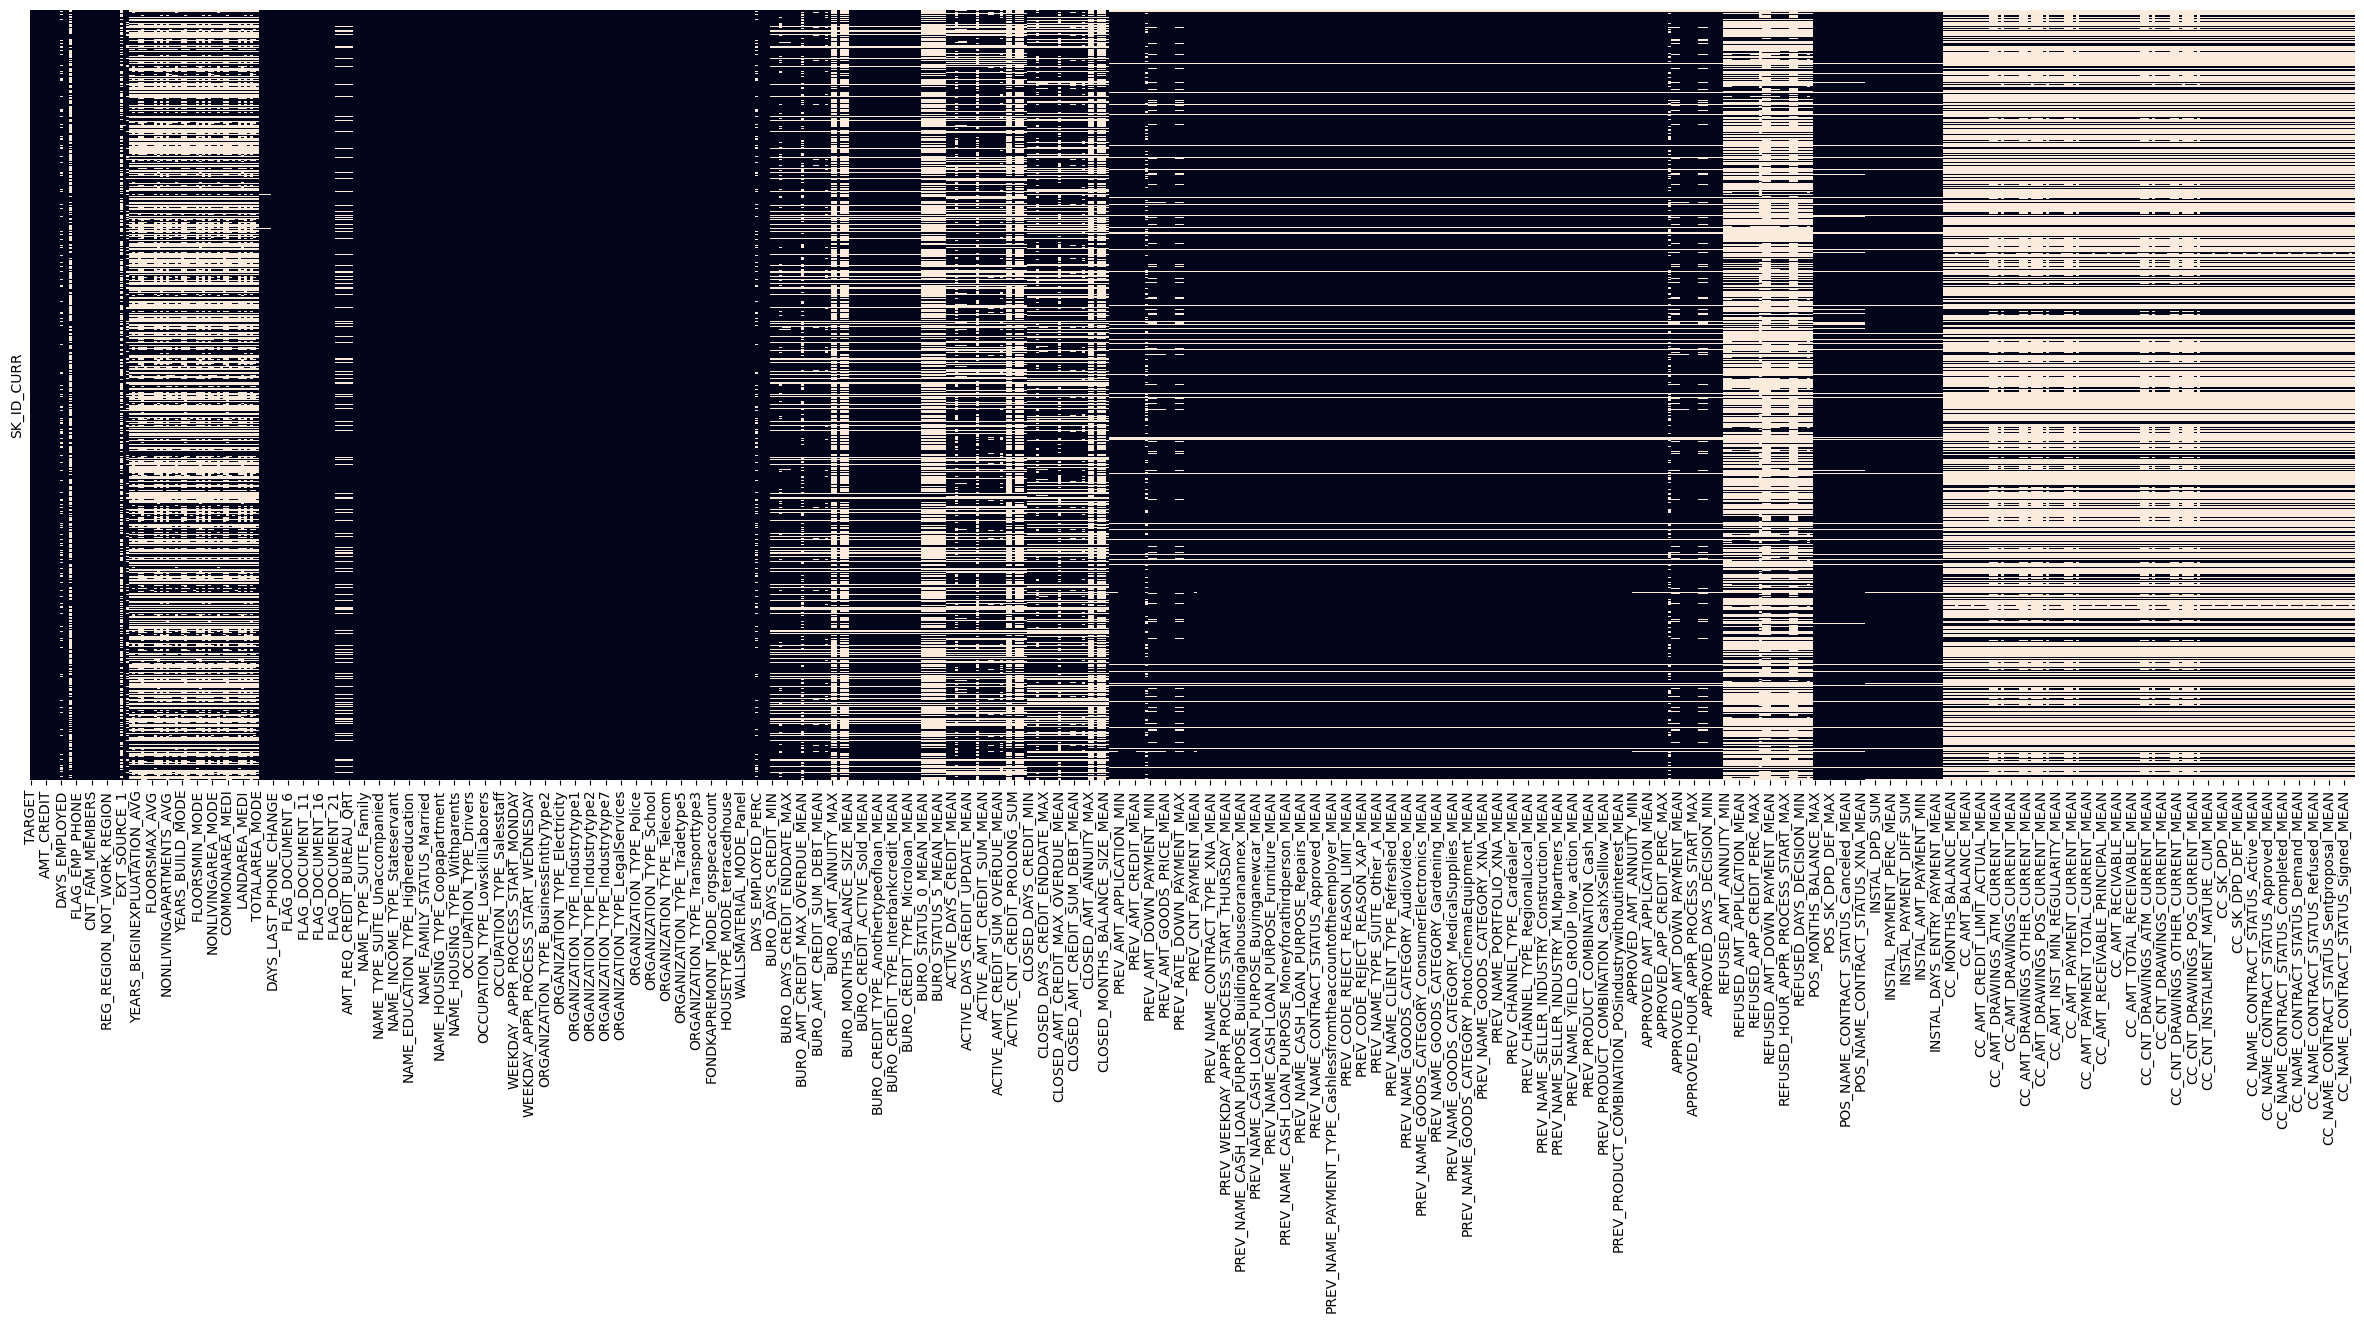

In [19]:
# Représentation graphique des valeurs manquantes (long à charger)
plt.figure(figsize=(30, 10))
ax = sns.heatmap(df.isna(), cbar=False, yticklabels=False)
ax.tick_params(left=False, bottom=True)

In [20]:
# Retrait des colonnes très peu informatives : colonnes qui ont plus de 80% de valeurs manquantes
threshold_value = 80
threshold = ((1-(threshold_value/100))*df.shape[0])
df = df.dropna(axis=1, thresh=threshold)

# 3) Analyse de la variable cible : TARGET (Loan Default)

In [18]:
df.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [19]:
df.TARGET.value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

<AxesSubplot:ylabel='TARGET'>

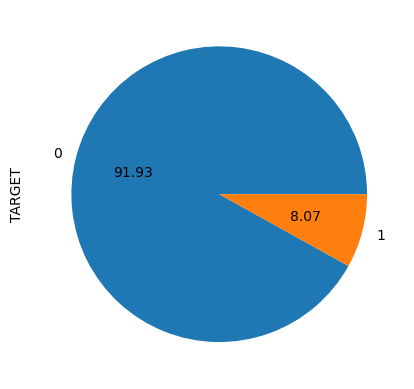

In [20]:
fig1, ax = plt.subplots()
ax.pie(df.TARGET.value_counts(normalize=True),
       labels=["0",
               "1"],
       autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p,
                                                    (p / 100) * sum(df.TARGET.value_counts())),
       startangle=0,
       pctdistance=0.8,
       explode=(0.05,
                0.05))  # draw circle
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
# Equal aspect ratio ensures that pie is drawn as a circle
plt.gca().add_artist(centre_circle)
plt.axis('equal')
plt.title(
    'Number of clients with difficulties (1) or not (0)\nto repay the loan')
plt.tight_layout()

# 4) Sélection des variables discriminantes (Feature Selection)

In [28]:
# Création d'un échantillon (équilibré) des données

df_light = df.groupby('TARGET', as_index=False).apply(
    lambda s: s.sample(20000, random_state=0))
df_light.reset_index(inplace=True)
df_light.set_index('SK_ID_CURR', inplace=True)
df_light.drop(columns='level_0', inplace=True)
df_light.fillna(0)

In [22]:
df_light.TARGET.value_counts()

0    20000
1    20000
Name: TARGET, dtype: int64

### A) L1 based selection

In [26]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

X = df_light.drop(columns="TARGET")
y = df_light['TARGET']


lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, ).fit(X.values, y)
model = SelectFromModel(lsvc, prefit=True)
X.columns[model.get_support()]

/Users/dubois/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Index(['FLAG_OWN_CAR', 'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       ...
       'CC_CNT_INSTALMENT_MATURE_CUM_SUM', 'CC_CNT_INSTALMENT_MATURE_CUM_VAR',
       'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_SUM', 'CC_SK_DPD_DEF_MAX',
       'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR',
       'CC_NAME_CONTRACT_STATUS_Active_SUM',
       'CC_NAME_CONTRACT_STATUS_Completed_SUM'],
      dtype='object', length=172)

In [27]:
len(list(X.columns[model.get_support()]))

172

In [36]:
df_light_selec = df[list(X.columns[model.get_support()])].copy()
df_light_selec['TARGET'] = df['TARGET']

In [37]:
list(df_light_selec.columns)

['FLAG_OWN_CAR',
 'DAYS_EMPLOYED',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_MEDI',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_16',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'NAME_CONTRACT_TYPE_Cashloans',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercialassociate',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Highereducation',
 'NAME_EDUCATION_TYPE_Lowersecondary',
 'NAME_EDUCATION_TYPE_Secondarysecondaryspecial',
 'NAME_FAMILY_STATUS_Civilmarriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Singlenotmarried',
 'NAME_HOUSING_TYPE_Houseapart

In [ ]:
list_feature = list(df_light_selec.columns)

list_feature = pd.Series(list_feature, name="Col_to_keep")

# Sauvegarde de la list des features
# list_feature.to_csv(path+'list_feature.csv', sep=";", index = False)

### B) Feature importance du meilleur modèle (Lightgbm)

In [21]:
import lightgbm as lgb


# Préparation des données pour la modélisation
X = df.drop(columns="TARGET").fillna(0)
y = df['TARGET']

# création du classifier lightgbm
clf = lgb.LGBMClassifier(objective="binary",
                         n_jobs=-1, is_unbalance=True)

# entraînement du modèle
clf.fit(X, y)

LGBMClassifier(is_unbalance=True, objective='binary')

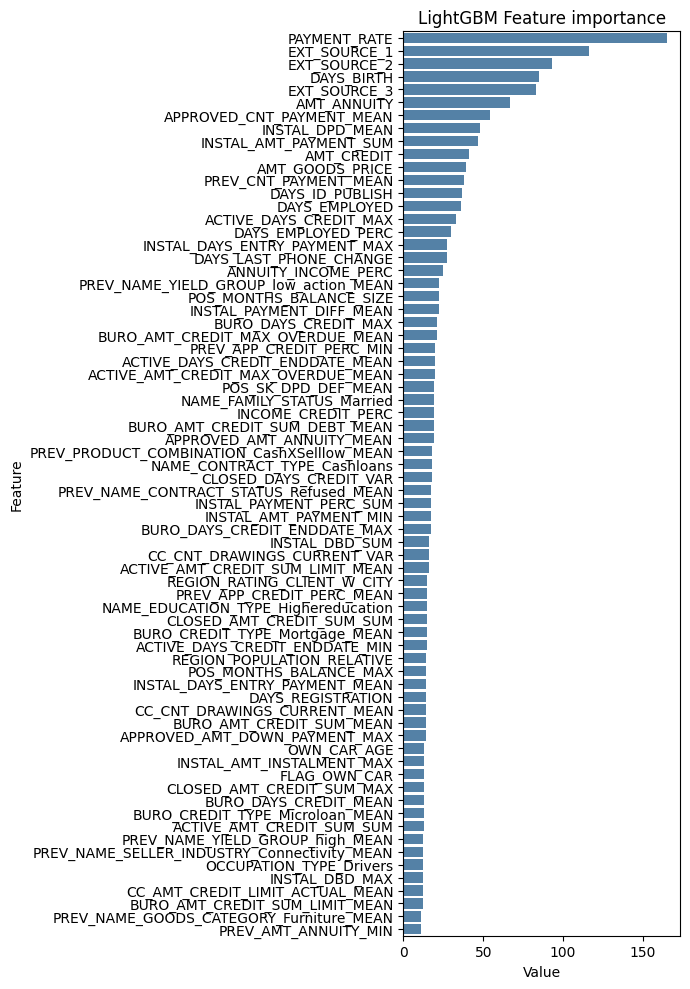

In [26]:
# Récupération de l'importance des features
feature_imp = pd.DataFrame(sorted(zip(
    clf.feature_importances_, X.columns), reverse=True), columns=['Value', 'Feature'])

# importance de chaque feature sur le total (%)
feature_imp["pct"] = (feature_imp.Value / sum(feature_imp.Value)) * 100

# importance de chaque feature sur le total (somme cumulée %)
feature_imp["pct_cum"] = np.cumsum(feature_imp["pct"])

# Représentation graphique
plt.figure(figsize=(7, 10))
sns.barplot(x="Value", y="Feature",
            data=feature_imp.iloc[:70], color='steelblue')
plt.title('LightGBM Feature importance')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Importance value')

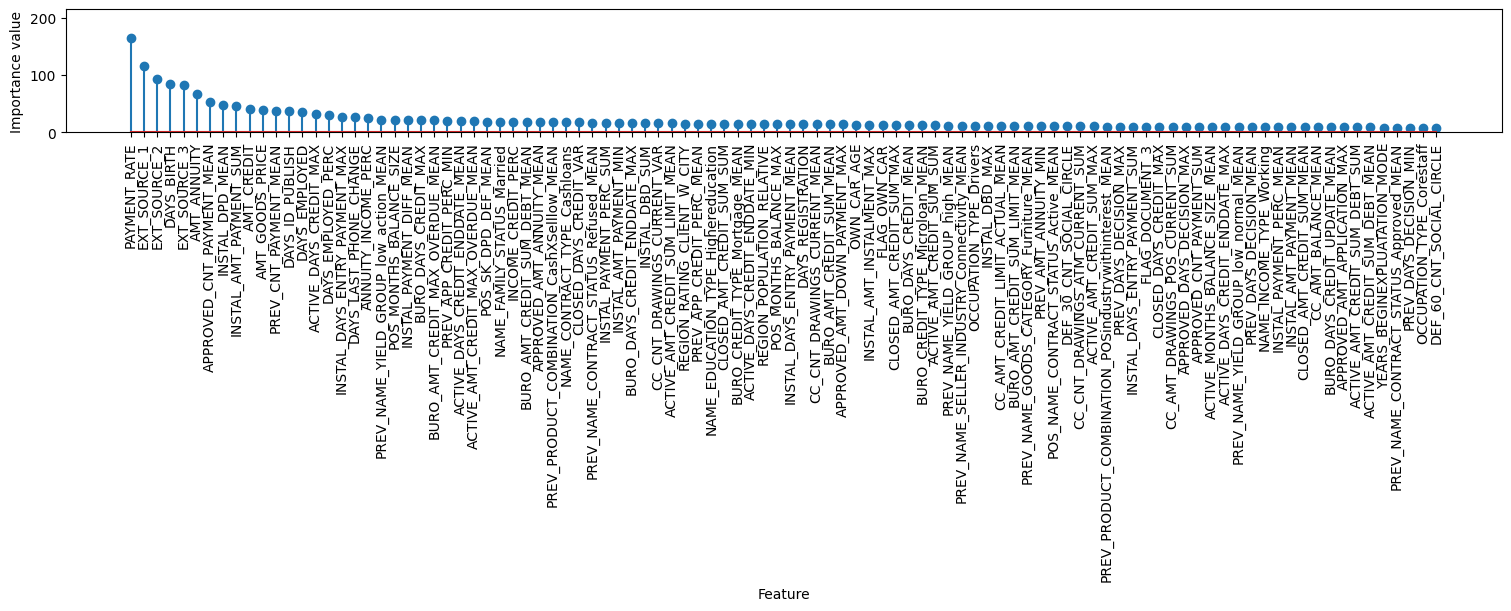

In [32]:
plt.figure(figsize=(15, 6), dpi=100, constrained_layout=True)
plt.stem(feature_imp['Value'].iloc[:100])
plt.xticks(range(0, len(feature_imp.iloc[:100].index)),
           feature_imp['Feature'].iloc[:100], rotation=90)
plt.ylim(0, feature_imp['Value'].iloc[:100].max()+50)
plt.xlabel("Feature")
plt.ylabel('Importance value')

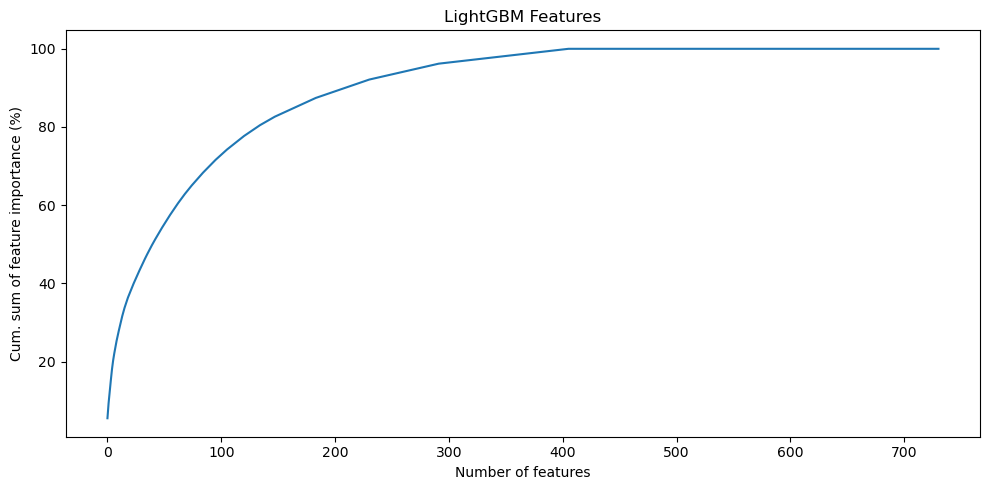

In [36]:
# Représentation graphique de la somme cumulée (%) de chaque feature

plt.figure(figsize=(10, 5))
sns.lineplot(x=feature_imp.index, y="pct_cum", data=feature_imp)
plt.title('LightGBM Features')
plt.xlabel("Number of features")
plt.ylabel("Cum. sum of feature importance (%)")
plt.tight_layout()
plt.show()

In [37]:
# Récupération de la liste des 62 features les plus importantes
list_feature_lgb = list(feature_imp.iloc[:62].Feature)

list_feature_lgb.append('TARGET')
list_feature_lgb = pd.Series(list_feature_lgb, name="Col_to_keep")

In [38]:
# Sauvegarde de la list des features
# list_feature_lgb.to_csv(path+'list_feature_lgb.csv', sep=";", index = False)